## Егоров Андрей, АДЭУ-211

Цель и задачи работы:
1. Познакомиться с понятием «большие данные» и способами их обработки;
2. Познакомиться с инструментом Apache Spark и возможностями, которые он предоставляет для обработки больших данных.
3. Получить навыки выполнения разведочного анализа данных использованием pyspark.


Датасет: https://www.kaggle.com/datasets/valakhorasani/mobile-device-usage-and-user-behavior-dataset


Этот набор данных обеспечивает всесторонний анализ моделей использования мобильных устройств и классификацию поведения пользователей. Он содержит 700 образцов пользовательских данных, включая такие показатели, как время использования приложений, время работы экрана, расход заряда батареи и потребление данных. Каждая запись относится к одному из пяти классов поведения пользователей, от лёгкого до экстремального использования, что позволяет проводить глубокий анализ и моделирование.

Импортируем необходимые библиотеки для работы со Spark

In [1]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.window import Window
from pyspark.sql.functions import udf, isnan, min, max, sum, count, desc, expr, avg
from pyspark.sql.types import IntegerType, LongType

from pyspark.ml.feature import StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier, LogisticRegressionModel, GBTClassificationModel, RandomForestClassificationModel

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import pandas as pd

In [2]:
! pip install pyspark

Импорт модулей, связанных с PySpark

In [3]:
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'

Инициализация сеанса Spark и загрузка файла

In [4]:
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'user_behavior_dataset.csv'
df = spark.read.csv(filename_data, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


Проведем обзор набора данных. Видно, что названия столбцов сбились, надо это исправить



In [5]:
df.printSchema()
df.show()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)

+-------+------------------+----------------+--------------------+--------------------+--------------------+--------------------+-------------------+---+------+-------------------+
|    _c0|               _c1|             _c2|                 _c3|                 _c4|                 _c5|                 _c6|                _c7|_c8|   _c9|               _c10|
+-------+------------------+----------------+--------------------+--------------------+--------------------+--------------------+-------------------+---+------+-------------------+
|User ID|      Device Model|Operating System|App Usage Time (m...

Меняем название столбцов для простоты ориентирования

In [6]:
df = df \
    .withColumnRenamed("_c0", "User ID") \
    .withColumnRenamed("_c1", "Device Model") \
    .withColumnRenamed("_c2", "Operating System") \
    .withColumnRenamed("_c3", "App Usage Time (min/day)") \
    .withColumnRenamed("_c4", "Screen On Time (hours/day)") \
    .withColumnRenamed("_c5", "Battery Drain (mAh/day)") \
    .withColumnRenamed("_c6", "Number of Apps Installed") \
    .withColumnRenamed("_c7", "Data Usage") \
    .withColumnRenamed("_c8", "Age") \
    .withColumnRenamed("_c9", "Gender") \
    .withColumnRenamed("_c10", "User Behavior Class")

In [7]:
df.show()

+-------+------------------+----------------+------------------------+--------------------------+-----------------------+------------------------+-------------------+---+------+-------------------+
|User ID|      Device Model|Operating System|App Usage Time (min/day)|Screen On Time (hours/day)|Battery Drain (mAh/day)|Number of Apps Installed|         Data Usage|Age|Gender|User Behavior Class|
+-------+------------------+----------------+------------------------+--------------------------+-----------------------+------------------------+-------------------+---+------+-------------------+
|User ID|      Device Model|Operating System|    App Usage Time (m...|      Screen On Time (h...|   Battery Drain (mA...|    Number of Apps In...|Data Usage (MB/day)|Age|Gender|User Behavior Class|
|      1|    Google Pixel 5|         Android|                     393|                       6.4|                   1872|                      67|               1122| 40|  Male|                  4|
|      2| 

Удаляем первую строчку, так как она дублирует название столбцов

In [8]:
condition_to_remove = (df.Age == "Age") & (df.Age == "Age") & \
                      (df.Gender == "Gender")
df_filtered = df.filter(~condition_to_remove)
df_filtered.show()

+-------+------------------+----------------+------------------------+--------------------------+-----------------------+------------------------+----------+---+------+-------------------+
|User ID|      Device Model|Operating System|App Usage Time (min/day)|Screen On Time (hours/day)|Battery Drain (mAh/day)|Number of Apps Installed|Data Usage|Age|Gender|User Behavior Class|
+-------+------------------+----------------+------------------------+--------------------------+-----------------------+------------------------+----------+---+------+-------------------+
|      1|    Google Pixel 5|         Android|                     393|                       6.4|                   1872|                      67|      1122| 40|  Male|                  4|
|      2|         OnePlus 9|         Android|                     268|                       4.7|                   1331|                      42|       944| 47|Female|                  3|
|      3|      Xiaomi Mi 11|         Android|          

Просмотрим типы данных. В итоге ве типы данных являются строкой, надо это исправить



In [9]:
df_filtered.printSchema()
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

root
 |-- User ID: string (nullable = true)
 |-- Device Model: string (nullable = true)
 |-- Operating System: string (nullable = true)
 |-- App Usage Time (min/day): string (nullable = true)
 |-- Screen On Time (hours/day): string (nullable = true)
 |-- Battery Drain (mAh/day): string (nullable = true)
 |-- Number of Apps Installed: string (nullable = true)
 |-- Data Usage: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- User Behavior Class: string (nullable = true)



,Column Name,Data type
0,User ID,string
1,Device Model,string
2,Operating System,string
3,App Usage Time (min/day),string
4,Screen On Time (hours/day),string
5,Battery Drain (mAh/day),string
6,Number of Apps Installed,string
7,Data Usage,string
8,Age,string
9,Gender,string


Изменяем типы данных на наиболее подходящие

In [48]:
pandas_df = df_filtered.withColumn("Battery Drain (mAh/day)", df_filtered["Battery Drain (mAh/day)"].cast(FloatType())) \
       .withColumn("App Usage Time (min/day)", df_filtered["App Usage Time (min/day)"].cast(IntegerType())) \
       .withColumn("User Behavior Class", df_filtered["User Behavior Class"].cast(IntegerType())) \
       .withColumn("Number of Apps Installed", df_filtered["Number of Apps Installed"].cast(IntegerType())) \
       .withColumn("Screen On Time (hours/day)", df_filtered["Screen On Time (hours/day)"].cast(IntegerType())) \
       .withColumn("Age", df_filtered["Age"].cast(IntegerType())) \
       .withColumn("Data Usage", df_filtered["Data Usage"].cast(IntegerType()))
pandas_df.printSchema()
pd.DataFrame(pandas_df.dtypes, columns = ['Column Name','Data type'])

root
 |-- User ID: string (nullable = true)
 |-- Device Model: string (nullable = true)
 |-- Operating System: string (nullable = true)
 |-- App Usage Time (min/day): integer (nullable = true)
 |-- Screen On Time (hours/day): integer (nullable = true)
 |-- Battery Drain (mAh/day): float (nullable = true)
 |-- Number of Apps Installed: integer (nullable = true)
 |-- Data Usage: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- User Behavior Class: integer (nullable = true)



,Column Name,Data type
0,User ID,string
1,Device Model,string
2,Operating System,string
3,App Usage Time (min/day),int
4,Screen On Time (hours/day),int
5,Battery Drain (mAh/day),float
6,Number of Apps Installed,int
7,Data Usage,int
8,Age,int
9,Gender,string


Считаем, сколько в датфрейме строк

In [40]:
pandas_df.describe().toPandas()
print(f'Общее количество {pandas_df.count()} строк, печатаем несколько первых строк:')
pandas_df.limit(5).toPandas()

Общее количество 700 строк, печатаем несколько первых строк:


,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage,Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6,1872.0,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4,1331.0,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4,761.0,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4,1676.0,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4,1367.0,58,988,31,Female,3


Выясняем, есть ли пропущенные значения. Как итог их нет.

In [12]:
str_col = ['Device Mode', 'Operating System', 'App Usage Time (min/day)', 'Data Usage', 'Gender']
num_col = ['Screen On Time (hours/day)','Age', 'User Behavior Class', 'Number of Apps Installed']
mis_val = {}
for index, column in enumerate(pandas_df.columns):
    if column in str_col:
        missing_count = pandas_df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        mis_val.update({column:missing_count})
    if column in num_col:
        mis_count = pandas_df.where(col(column).isin([0,None,np.nan])).count()
        mis_val.update({column:missing_count})

mis_df = pd.DataFrame.from_dict([mis_val])
mis_df

,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Number of Apps Installed,Data Usage,Age,Gender,User Behavior Class
0,0,0,0,0,0,0,0,0


Рассчитаем статистические показатели: квартили, среднее, дисперсию, медиану

In [50]:
print('Number of Apps Installed')
from pyspark.sql.functions import col, avg, percentile_approx, variance
quartiles = pandas_df.select(
    percentile_approx("Number of Apps Installed", 0.25).alias("1_quar"),
    percentile_approx("Number of Apps Installed", 0.5).alias("2_quar"),
    percentile_approx("Number of Apps Installed", 0.75).alias("3_quar")
)
quartiles.show()
print('age')
from pyspark.sql.functions import col, avg, percentile_approx, variance
quartiles = pandas_df.select(
    percentile_approx("age", 0.25).alias("1_quar"),
    percentile_approx("age", 0.5).alias("2_quar"),
    percentile_approx("age", 0.75).alias("3_quar")
)
quartiles.show()
print('Screen On Time (hours/day)')
from pyspark.sql.functions import col, avg, percentile_approx, variance
quartiles = pandas_df.select(
    percentile_approx("Screen On Time (hours/day)", 0.25).alias("1_quar"),
    percentile_approx("Screen On Time (hours/day)", 0.5).alias("2_quar"),
    percentile_approx("Screen On Time (hours/day)", 0.75).alias("3_quar")
)
quartiles.show()

Number of Apps Installed
+------+------+------+
|1_quar|2_quar|3_quar|
+------+------+------+
|    26|    49|    74|
+------+------+------+

age
+------+------+------+
|1_quar|2_quar|3_quar|
+------+------+------+
|    28|    38|    49|
+------+------+------+

Screen On Time (hours/day)
+------+------+------+
|1_quar|2_quar|3_quar|
+------+------+------+
|     2|     4|     7|
+------+------+------+



In [51]:
print('Number of Apps Installed')
stat = pandas_df.select(
    avg("Number of Apps Installed").alias("Среднее количество приложений"),
    variance("Number of Apps Installed").alias("Дисперсия"),
    percentile_approx("Number of Apps Installed", 0.5).alias("Медиана")
)
stat.show()
print('age')
stat = pandas_df.select(
    avg("age").alias("Средний возраст"),
    variance("age").alias("Дисперсия"),
    percentile_approx("age", 0.5).alias("Медиана")
)
stat.show()
print('Screen On Time (hours/day)')
stat = pandas_df.select(
    avg("Screen On Time (hours/day)").alias("Среднее время экрана"),
    variance("Screen On Time (hours/day)").alias("Дисперсия"),
    percentile_approx("Screen On Time (hours/day)", 0.5).alias("Медиана")
)
stat.show()

Number of Apps Installed
+-----------------------------+----------------+-------+
|Среднее количество приложений|       Дисперсия|Медиана|
+-----------------------------+----------------+-------+
|            50.68142857142857|725.942716125077|     49|
+-----------------------------+----------------+-------+

age
+-----------------+------------------+-------+
|  Средний возраст|         Дисперсия|Медиана|
+-----------------+------------------+-------+
|38.48285714285714|144.31014919272437|     38|
+-----------------+------------------+-------+

Screen On Time (hours/day)
+--------------------+-----------------+-------+
|Среднее время экрана|        Дисперсия|Медиана|
+--------------------+-----------------+-------+
|   4.837142857142857|9.252409564684259|      4|
+--------------------+-----------------+-------+



Визуализация

In [17]:
pandas_df1 = pandas_df.select('Number of Apps Installed', 'User Behavior Class').toPandas()

Провизуализируем класс поведения пользователя сколько их

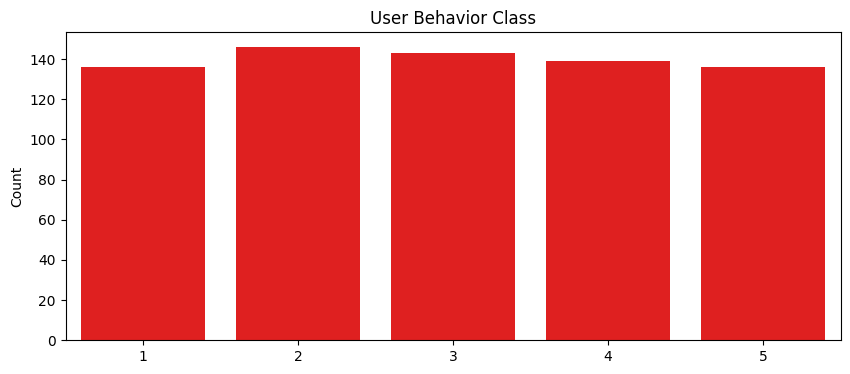

In [18]:
plt.figure(figsize=(10, 4))
ax = sns.countplot(x='User Behavior Class', data=pandas_df1, color='red')
plt.title('User Behavior Class')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

Провизуализируем сколько у каждого пользователя приложений

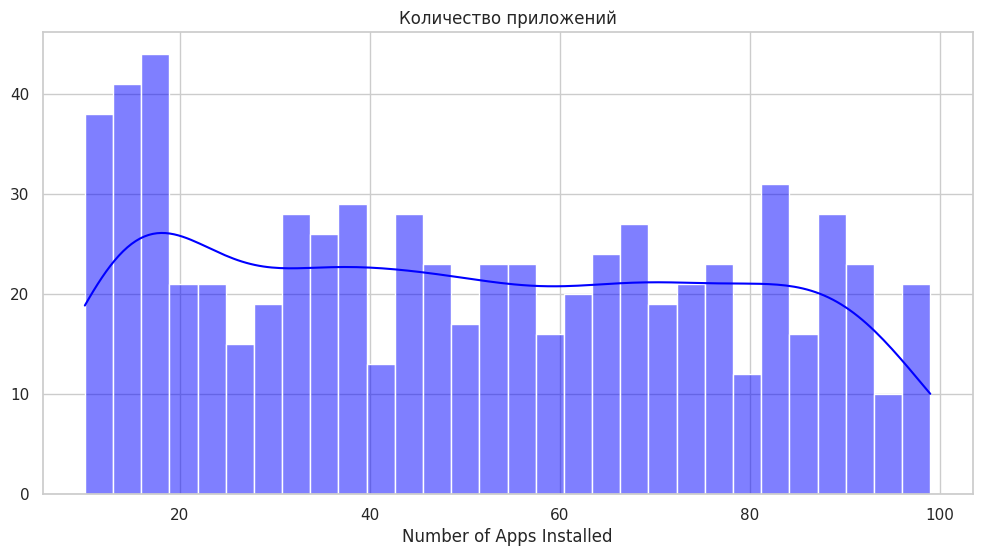

In [52]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(pandas_df1['Number of Apps Installed'], bins=30, kde=True, color='blue')
plt.title('Количество приложений')
plt.xlabel('Number of Apps Installed')
plt.ylabel('')
plt.show()

UDF используются для расширения функций платформы и повторного использования этих функций в нескольких DataFrame.

Рассчитать ежедневную эффективность батареи

In [23]:
def calculate_battery_efficiency(screen_on_time, battery_drain):
    if battery_drain == 0:
        return 0.0
    return screen_on_time / battery_drain

battery_efficiency_udf = udf(calculate_battery_efficiency, FloatType())

Категоризация времени использования приложений

In [41]:
def categorize_app_usage(app_usage_time):
    try:
        # Приведение к числу
        app_usage_time = float(app_usage_time)

        if app_usage_time < 60:
            return "Low"
        elif 60 <= app_usage_time < 120:
            return "Medium"
        else:
            return "High"
    except (ValueError, TypeError):
        return "Unknown"  # Возвращаем "Unknown" в случае ошибки
categorize_app_usage_udf = udf(categorize_app_usage, StringType())
spark_df_with_category = pandas_df.withColumn("App Usage Category", categorize_app_usage_udf(pandas_df["App Usage Time (min/day)"]))
spark_df_with_category.show()

+-------+------------------+----------------+------------------------+--------------------------+-----------------------+------------------------+----------+---+------+-------------------+------------------+
|User ID|      Device Model|Operating System|App Usage Time (min/day)|Screen On Time (hours/day)|Battery Drain (mAh/day)|Number of Apps Installed|Data Usage|Age|Gender|User Behavior Class|App Usage Category|
+-------+------------------+----------------+------------------------+--------------------------+-----------------------+------------------------+----------+---+------+-------------------+------------------+
|      1|    Google Pixel 5|         Android|                     393|                         6|                 1872.0|                      67|      1122| 40|  Male|                  4|              High|
|      2|         OnePlus 9|         Android|                     268|                         4|                 1331.0|                      42|       944| 47|Female|

Выводы:
При исследовании данных были обнаружены количественные и категориальные признаки.
В представленной выборке не было ни одного пропущенного значения.
Также были посчитаны основные статистические показатели, включая среднее, медиану, квартили, дисперсию.
Данные были визуализированы с помощью столбчатых диаграм.
Было написано несколько пользовательских функций (UDF).